In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
base_path = "/content/drive/MyDrive/IMAGENES_SATELITALES_INUNDACIONES/2021/GUYANA/Sentinel2"

In [ ]:
# Importar TensorFlow y verificar la versión
import tensorflow as tf
print(tf.__version__)

# Importar otras librerías útiles
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2  # Si necesitas manipulación de imágenes avanzada
from sklearn.model_selection import train_test_split  # Para dividir los datos

2.14.0


In [ ]:
# Rutas de las carpetas
base_path = "/content/drive/MyDrive/IMAGENES_SATELITALES_INUNDACIONES/2021/GUYANA/Sentinel2"
before_path = os.path.join(base_path, "BEFORE")
after_path = os.path.join(base_path, "AFTER")
mask_path = os.path.join(base_path, "MASK")

# Función para cargar imágenes desde una carpeta
def load_images_from_folder(folder):
    images = []
    filenames = sorted(os.listdir(folder))  # Asegura orden alfabético
    for filename in filenames:
        img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_COLOR)
        if img is not None:
            images.append(img)
    return images

# Cargar imágenes
before_images = load_images_from_folder(before_path)
after_images = load_images_from_folder(after_path)
mask_images = load_images_from_folder(mask_path)

In [ ]:
# Normalizar imágenes
def normalize_images(images):
    normalized_images = []
    for img in images:
        img = img / 255.0  # Normalizar
        normalized_images.append(img)
    return np.array(normalized_images)


In [ ]:
# Aplicar normalización
before_images = normalize_images(before_images)
after_images = normalize_images(after_images)
mask_images = normalize_images(mask_images)

In [ ]:
from sklearn.model_selection import train_test_split

# Dividir las imágenes 'before'
before_train, before_test = train_test_split(before_images, test_size=0.3, random_state=42)

# Dividir las imágenes 'after'
after_train, after_test = train_test_split(after_images, test_size=0.3, random_state=42)

# Dividir las máscaras
mask_train, mask_test = train_test_split(mask_images, test_size=0.3, random_state=42)


In [ ]:
# Preparar datos de entrada
X_train = [np.array(before_train), np.array(after_train)]
Y_train = np.array(mask_train)

X_test = [np.array(before_test), np.array(after_test)]
Y_test = np.array(mask_test)


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, concatenate, Conv2D, UpSampling2D

# Cargar InceptionV3 preentrenado, sin las capas superiores
base_inception_model = InceptionV3(weights='imagenet', include_top=False)

# Definir las entradas para las imágenes 'antes' y 'después'
input_before = Input(shape=(256, 256, 3))
input_after = Input(shape=(256, 256, 3))

# Pasar las imágenes 'antes' y 'después' a través de InceptionV3
features_before = base_inception_model(input_before)
features_after = base_inception_model(input_after)

# Combinar las características extraídas de las imágenes 'antes' y 'después'
combined_features = concatenate([features_before, features_after])

# Agregar capas adicionales según sea necesario
x = Conv2D(512, (3, 3), activation='relu', padding='same')(combined_features)
x = UpSampling2D((2, 2))(x)  # Upsampling a 16x16
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)  # Upsampling a 32x32
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)  # Upsampling a 64x64
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)  # Upsampling a 128x128
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)  # Upsampling a 256x256
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)  # Upsampling a 512x512
x = Conv2D(1, (3, 3), activation='relu', padding='same')(x)
x = tf.image.resize(x, [256, 256])  # Redimensionar a 299x299

output_layer = x

model = Model(inputs=[input_before, input_after], outputs=output_layer)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# Ahora puedes proceder con el entrenamiento del modelo:
# history = model.fit(X_train, Y_train, epochs=10, validation_split=0.2, batch_size=32)


In [ ]:
history = model.fit(
    X_train,
    Y_train,
    epochs=10,
    validation_split=0.2,
    batch_size=32
)


Epoch 1/10
1/1 [==============================] - 5s 5s/step - loss: 2.4726 - accuracy: 0.8394 - val_loss: 1.7450 - val_accuracy: 0.8866
Epoch 2/10
1/1 [==============================] - 5s 5s/step - loss: 2.4726 - accuracy: 0.8394 - val_loss: 1.7435 - val_accuracy: 0.8866
Epoch 4/10
1/1 [==============================] - 5s 5s/step - loss: 2.4726 - accuracy: 0.8394 - val_loss: 1.7413 - val_accuracy: 0.8866
Epoch 5/10
1/1 [==============================] - 5s 5s/step - loss: 2.4726 - accuracy: 0.8394 - val_loss: 1.7387 - val_accuracy: 0.8866
Epoch 6/10
1/1 [==============================] - 5s 5s/step - loss: 2.4726 - accuracy: 0.8394 - val_loss: 1.7342 - val_accuracy: 0.8867
Epoch 7/10
1/1 [==============================] - 5s 5s/step - loss: 2.4726 - accuracy: 0.8394 - val_loss: 1.7193 - val_accuracy: 0.8867
Epoch 8/10
1/1 [==============================] - 5s 5s/step - loss: 2.4726 - accuracy: 0.8394 - val_loss: 1.7162 - val_accuracy: 0.8867
Epoch 9/10
1/1 [=========================

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, Y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


1/1 [==============================] - 1s 608ms/step - loss: 0.9117 - accuracy: 0.9388
Test Loss: 0.9116564989089966, Test Accuracy: 0.9387732744216919


In [ ]:
history_dict = history.history

In [ ]:
# Calcular los promedios
average_metrics = {key: sum(values) / len(values) for key, values in history_dict.items()}

# Imprimir los promedios
print("Promedios de Métricas:")
for key, value in average_metrics.items():
    print(f"{key}: {value}")

Promedios de Métricas:
loss: 2.4725961446762086
accuracy: 0.8393748283386231
val_loss: 1.731286895275116
val_accuracy: 0.8866766333580017


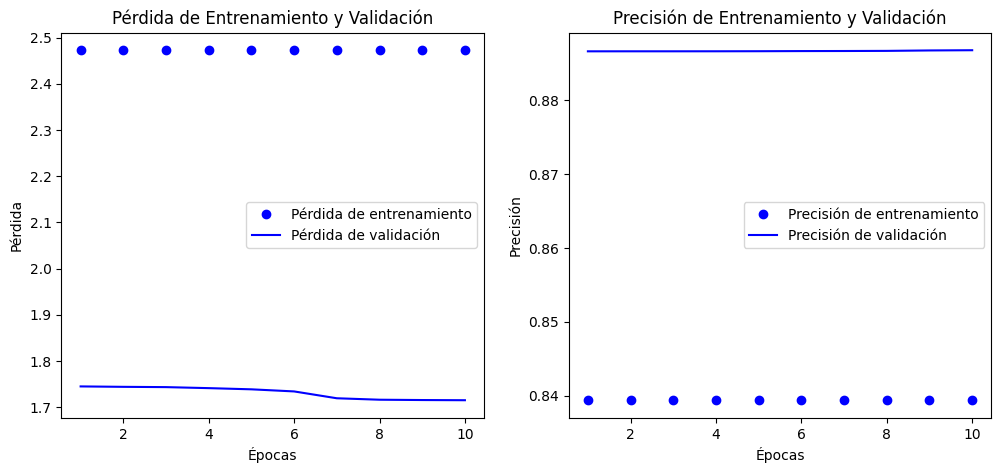

In [ ]:
import matplotlib.pyplot as plt

# Asumiendo que 'history' es el objeto retornado por model.fit()
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)

# Graficar la pérdida
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo', label='Pérdida de entrenamiento')
plt.plot(epochs, val_loss, 'b', label='Pérdida de validación')
plt.title('Pérdida de Entrenamiento y Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Graficar la precisión
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'bo', label='Precisión de entrenamiento')
plt.plot(epochs, val_accuracy, 'b', label='Precisión de validación')
plt.title('Precisión de Entrenamiento y Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.show()


LSTM

In [ ]:
# Aplicar normalización
before_images = normalize_images(before_images)
after_images = normalize_images(after_images)
#mask_images = normalize_images(mask_images)

In [ ]:
import numpy as np
from sklearn.feature_extraction.image import extract_patches_2d
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Parámetros
patch_size = (5, 5)

# Preparar listas para almacenar parches y etiquetas
patches_before_list = []
patches_after_list = []
labels_list = []

# Iterar sobre cada conjunto de imágenes y máscaras
for img_before, img_after, change in zip(before_images, after_images, mask_images):
    # Extraer parches para las imágenes 'before' y 'after'
    patches_before = extract_patches_2d(img_before, patch_size)
    patches_after = extract_patches_2d(img_after, patch_size)

    # Extraer parches para las máscaras y generar etiquetas
    patches_change = extract_patches_2d(change, patch_size)
    labels = (patches_change.mean(axis=(1, 2, 3)) > 0.5).astype(int)

    # Agregar a las listas
    patches_before_list.append(patches_before)
    patches_after_list.append(patches_after)
    labels_list.append(labels)

# Convertir listas a arrays de Numpy
patches_before_array = np.vstack(patches_before_list)
patches_after_array = np.vstack(patches_after_list)
labels_array = np.concatenate(labels_list)

# Concatenar parches 'before' y 'after'
X_patches = np.concatenate([patches_before_array, patches_after_array], axis=-1)
X_patches_seq = X_patches.reshape(-1, 25, 6)  # 25 pasos de tiempo, 6 características por paso

# Verificar dimensiones
assert X_patches_seq.shape[0] == labels_array.shape[0]


In [ ]:
model = Sequential()
model.add(LSTM(128, input_shape=(25, 6), return_sequences=True))  # Ajusta según la forma de tus datos
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Capa de salida para clasificación binaria

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 'Precision', 'Recall', 'AUC']
)


In [ ]:
from sklearn.model_selection import train_test_split

# Dividir en entrenamiento+prueba (35% del total) y no-utilizados (65%)
X_temp, X_no_use, Y_temp, Y_no_use = train_test_split(
    X_patches_seq, labels_array, test_size=0.65, random_state=42
)
# Calcular la proporción del conjunto de prueba respecto al 35% del conjunto total
# Esto es 10% del total / 35% del total
test_ratio = 0.3 / 0.35

# Dividir en entrenamiento (25% del total) y prueba (10% del total)
X_train, X_test, Y_train, Y_test = train_test_split(
    X_temp, Y_temp, test_size=test_ratio, random_state=42
)


In [ ]:
history = model.fit(
    X_train,
    Y_train,
    epochs=10,
    validation_data=(X_test, Y_test),
    batch_size=32
)


Epoch 1/10
2977/2977 [==============================] - 315s 105ms/step - loss: 0.1246 - accuracy: 0.9510 - precision: 0.8507 - recall: 0.8108 - auc: 0.9790 - val_loss: 0.1154 - val_accuracy: 0.9533 - val_precision: 0.8460 - val_recall: 0.8368 - val_auc: 0.9831
Epoch 2/10
2977/2977 [==============================] - 354s 119ms/step - loss: 0.1231 - accuracy: 0.9510 - precision: 0.8523 - recall: 0.8084 - auc: 0.9794 - val_loss: 0.1200 - val_accuracy: 0.9527 - val_precision: 0.8389 - val_recall: 0.8426 - val_auc: 0.9826
Epoch 3/10
2977/2977 [==============================] - 311s 105ms/step - loss: 0.1214 - accuracy: 0.9524 - precision: 0.8546 - recall: 0.8167 - auc: 0.9799 - val_loss: 0.1423 - val_accuracy: 0.9411 - val_precision: 0.7509 - val_recall: 0.9011 - val_auc: 0.9812
Epoch 4/10
2977/2977 [==============================] - 365s 123ms/step - loss: 0.1209 - accuracy: 0.9515 - precision: 0.8478 - recall: 0.8186 - auc: 0.9804 - val_loss: 0.1265 - val_accuracy: 0.9500 - val_precision

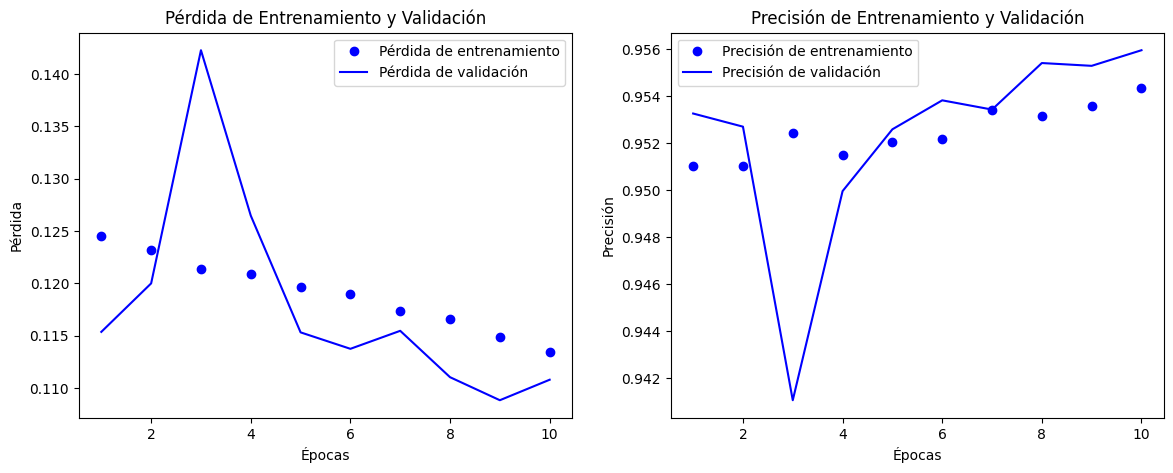

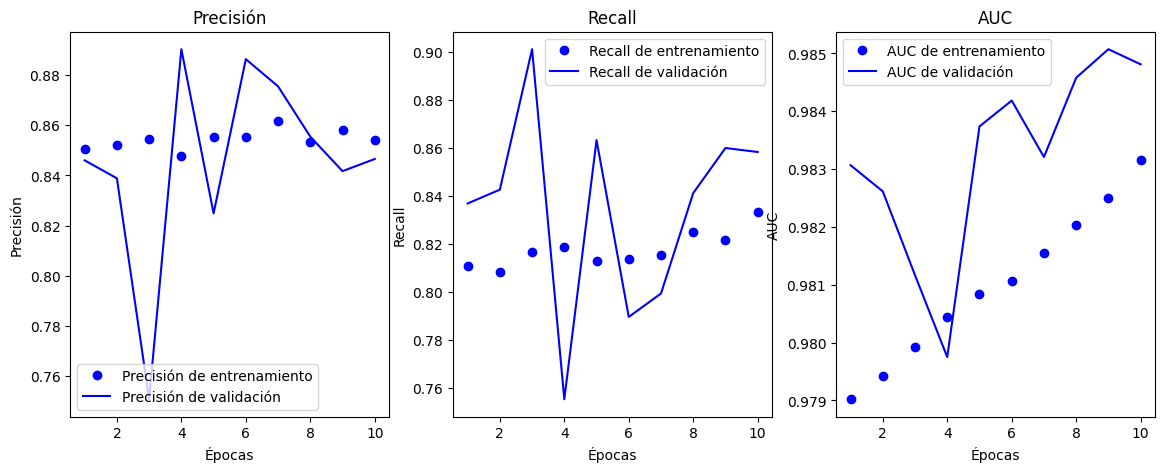

In [ ]:
import matplotlib.pyplot as plt

# Asumiendo que 'history' es el objeto retornado por model.fit()
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
precision = history.history['precision']
val_precision = history.history['val_precision']
recall = history.history['recall']
val_recall = history.history['val_recall']
auc = history.history['auc']
val_auc = history.history['val_auc']

epochs = range(1, len(loss) + 1)

# Graficar la pérdida
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo', label='Pérdida de entrenamiento')
plt.plot(epochs, val_loss, 'b', label='Pérdida de validación')
plt.title('Pérdida de Entrenamiento y Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Graficar la precisión
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'bo', label='Precisión de entrenamiento')
plt.plot(epochs, val_accuracy, 'b', label='Precisión de validación')
plt.title('Precisión de Entrenamiento y Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.show()

# Graficar otras métricas (precisión, recall, AUC)
plt.figure(figsize=(14, 5))

# Precisión
plt.subplot(1, 3, 1)
plt.plot(epochs, precision, 'bo', label='Precisión de entrenamiento')
plt.plot(epochs, val_precision, 'b', label='Precisión de validación')
plt.title('Precisión')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Recall
plt.subplot(1, 3, 2)
plt.plot(epochs, recall, 'bo', label='Recall de entrenamiento')
plt.plot(epochs, val_recall, 'b', label='Recall de validación')
plt.title('Recall')
plt.xlabel('Épocas')
plt.ylabel('Recall')
plt.legend()

# AUC
plt.subplot(1, 3, 3)
plt.plot(epochs, auc, 'bo', label='AUC de entrenamiento')
plt.plot(epochs, val_auc, 'b', label='AUC de validación')
plt.title('AUC')
plt.xlabel('Épocas')
plt.ylabel('AUC')
plt.legend()

plt.show()
